# Project II: Online learning with sample selection and change detection

### EP 2420 - Network Analytics

Ruihan Zhang
Dec 12, 2022

In [131]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import ensemble, preprocessing
from sklearn.model_selection import train_test_split

print('pandas =', pd.__version__)
print('numpy =', np.__version__)

# Read data and preprocessing
X1 = pd.read_csv('./JNSM_VoD_flashcrowd_1/X.csv').drop(columns=['TimeStamp','Unnamed: 0'])
X2 = pd.read_csv('./JNSM_VoD_flashcrowd_2/X.csv').drop(columns=['TimeStamp','Unnamed: 0'])
X = pd.concat([X1,X2])
y1 = pd.read_csv('./JNSM_VoD_flashcrowd_1/Y.csv')['DispFrames']
y2 = pd.read_csv('./JNSM_VoD_flashcrowd_2/Y.csv')['DispFrames']
y = pd.concat([y1,y2]).to_numpy()
select = np.load('select_VoD.npy')

# X1 = pd.read_csv('./JNSM_KV_flashcrowd_1/X.csv').drop(columns=['TimeStamp','Unnamed: 0'])
# X2 = pd.read_csv('./JNSM_KV_flashcrowd_2/X.csv').drop(columns=['TimeStamp','Unnamed: 0'])
# X = pd.concat([X1,X2])
# y1 = pd.read_csv('./JNSM_KV_flashcrowd_1/Y.csv')['ReadsAvg']
# y2 = pd.read_csv('./JNSM_KV_flashcrowd_2/Y.csv')['ReadsAvg']
# y = pd.concat([y1,y2]).to_numpy()
# select = np.load('select_KV.npy')

del(X1,X2, y1, y2)

# standardization
X = preprocessing.scale(X, axis=0)

pandas = 1.4.4
numpy = 1.23.4


/Users/ruihanzhang/opt/anaconda3/envs/netAna/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:258: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(


In [2]:
# out-lier removal, 
T = 54 # VoD 54
X_cut = X[(np.abs(X) < T).all(axis=1)]
y_cut = y[(np.abs(X) < T).all(axis=1)]
num = X.shape[0] - X_cut.shape[0]
print('Removed outliers: ', num)
# select top features
X_cut = X_cut[:,select]
print('Selected features: ', len(select))

Removed outliers:  341
Selected features:  16


In [3]:
# our evaluating metric: Normalized Mean Absolute Error
def NMAE(y_true, y_pred):
    return abs(y_true - y_pred).mean() / abs(y_pred).mean()

In [132]:
def rs_update(t0, index, cache):
    rgn = np.random.randint(0, index-t0) # random generated number
    if rgn < len(cache):
        cache[rgn] = index
    return cache

In [141]:
def detect_drift( t, drift_points, ph ):
    # train teacher and student with previous 1000 samples
    X_train = X_cut[t-1000:t,:]
    y_train = y_cut[t-1000:t]
    teacher.fit(X_train, y_train)
    y_teacher = teacher.predict(X_train)
    student.fit(X_train, y_teacher)
    # detect all remainings together
    predict1 = teacher.predict(X_cut[t:,:])
    predict2 = student.predict(X_cut[t:,:])
    loss = np.abs(predict1 - predict2) / predict1
    
    for idx, li in enumerate(loss):
        ph.add_element(li)
        if ph.detected_change():
            drift_points.append(t+idx)
            detect_drift(t+idx , drift_points, ph)
            break # this break is important, ensure we only use the first detected point

In [194]:
points = []
from skmultiflow.drift_detection import PageHinkley
iter = 100
length = 0
num = 0 
for j in range(iter):
    t0 = np.random.randint(1,5001)
    teacher = ensemble.RandomForestRegressor(n_estimators=20, n_jobs=-1, random_state=42, warm_start=False)
    student = ensemble.RandomForestRegressor(n_estimators=20, n_jobs=-1, random_state=42, warm_start=False)
    ph = PageHinkley(min_instances=100 ,delta=0.0001 , threshold=5)
    drift_points = []
    detect_drift(t0+3000, drift_points, ph)
    print('detected: {}'.format(drift_points))
    # length += (len(y_cut) - t0 - 3000) / len(drift_points)
    num += len(drift_points)
    points.extend(drift_points) 
# print(length/iter)
print(num/iter)

detected: [5595, 6315, 7032, 7775, 8275, 8607, 10161, 11941, 12589, 13797, 14329, 14654, 15300, 16474, 16676, 18166, 19422, 21220, 33871, 34275, 34534]
detected: [5343, 6297, 7071, 7730, 8272, 8592, 10202, 10373, 11875, 12459, 12696, 13743, 14359, 14704, 15707, 16263, 16683, 18229, 19254, 19434, 30039, 31037, 32276, 33077, 34014, 34274]
detected: [5412, 7031, 7731, 8261, 8787, 10187, 11859, 12618, 13752, 14523, 16499, 16665, 16805, 17052, 18018, 19408, 21225, 22926, 23957, 25195, 25502, 27001, 27865, 28477, 29413, 31268, 31720, 32313, 33066, 33925, 34543]
detected: [5607, 6300, 6886, 7122, 7667, 8317, 8674, 10102, 12747, 13755, 14569, 15695, 16442, 16813, 17070, 18012, 19409, 21221, 22927, 23880, 25128, 25649, 26807]
detected: [7042, 7833, 8244, 8809, 10090, 12836, 13742, 14359, 14704, 15707, 16263, 16683, 18229, 19254, 19434, 30039, 31037, 32276, 33077, 34014, 34274]
detected: [7082, 7790, 8220, 8810, 10069, 12836, 13742, 14359, 14704, 15707, 16263, 16683, 18229, 19254, 19434, 30039, 

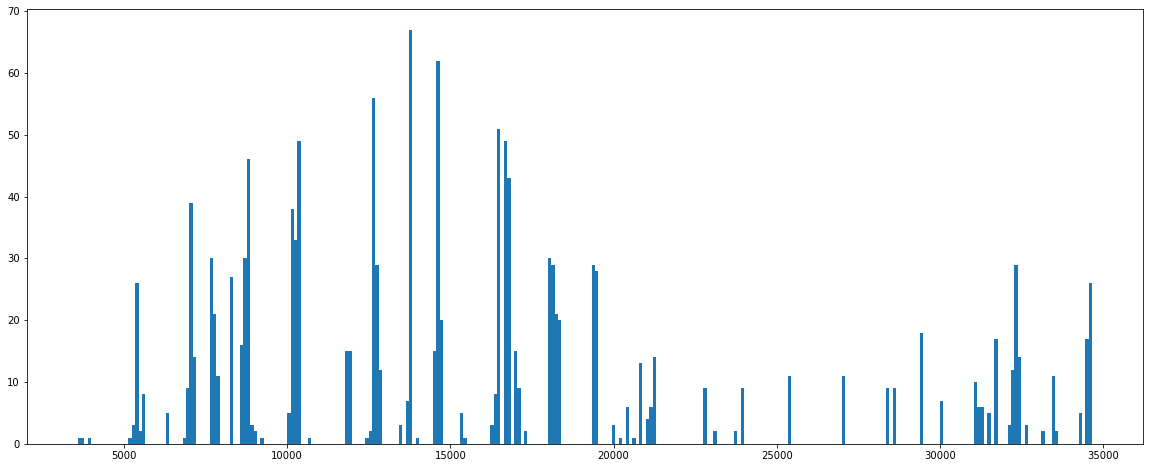

In [149]:
fig = plt.figure(figsize=(20,8))
plt.hist(points, bins=300)
plt.show()

In [205]:
from skmultiflow.drift_detection import PageHinkley

iter = 100
error = np.zeros([4,iter])

for i, n in enumerate([32,128,512,2048]):
    err = []
    num = 0
    for j in range(iter):
        # # initialize
        t0 = np.random.randint(1,5001)
        cache = np.arange(t0, t0+n)
        for t in range(t0+n,t0+3000):
            cache = rs_update(t0, t, cache)

        # # STUDD detection
        teacher = ensemble.RandomForestRegressor(n_estimators=20, n_jobs=-1, random_state=42, warm_start=False)
        student = ensemble.RandomForestRegressor(n_estimators=20, n_jobs=-1, random_state=42, warm_start=False)
        ph = PageHinkley(min_instances=100 ,delta=0.001 , threshold=8)
        drift_points = []
        detect_drift(t0+3000, drift_points, ph)
        print('detected: {}'.format(drift_points))
        num += len(drift_points)

        # first model prediction
        regr = ensemble.RandomForestRegressor(n_estimators=20, n_jobs=-1, warm_start=False)
        regr.fit(X_cut[cache,:], y_cut[cache])

        predictions = regr.predict(X_cut[t0+3000:,:])

        # run model updating
        left = t0+3000
        for right in drift_points:
            # revservoir sampling from current point to next detection point
            for t in range(left,right):
                cache = rs_update(t0, t, cache)
            regr.fit(X_cut[cache,:], y_cut[cache])
            predictions[right-t0-3000:] = regr.predict(X_cut[right:,:])
            left = right
        error[i,j] =  NMAE(y_cut[t0+3000:], predictions)
    print('Average detections:{}  (n={})'.format(num/iter, n))

detected: [5390, 7101, 7723, 8328, 8752, 10229, 10376, 12664, 13819, 14581, 16658, 18303, 19400, 21228, 32390, 34656]
detected: [7074, 7739, 8768, 10343, 12702, 13523, 14573, 16644, 16826, 18027, 19413, 30043, 31139, 32596, 33416, 34312]
detected: [6889, 8865, 10171, 12839, 13744, 14616, 16488, 16691, 17063, 18107, 20043, 31746, 32274, 34613]
detected: [15550, 16499, 16698, 18131, 19432, 32358]
detected: [8804, 10306, 10404, 12676, 13799, 14560, 16456, 16753, 18263, 19507, 32324, 34564]
detected: [5373, 8621, 10170, 12775, 13778, 14591, 16710, 17059, 18068, 22894, 23953, 25169, 25594, 27022, 32291, 34520]
detected: [5369, 6906, 8836, 10189, 12659, 14735, 16422, 17022, 18066, 21189]
detected: [8290, 8821, 10370, 11903, 12700, 13764, 14664, 16496, 16812, 18231, 20858]
detected: [5399, 7063, 7852, 8325, 8837, 10321, 11843, 12697, 13796, 14560, 16456, 16753, 18263, 19507, 32324, 34564]
detected: [5372, 7034, 7784, 8326, 8667, 10064, 12706, 13736, 14585, 16703, 18158, 22796, 23944, 25425, 2

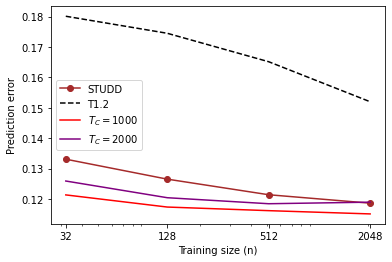

In [206]:
fig, ax = plt.subplots()

x = [32,128,512,2048]
y = error.mean(1)
ci = 1.96 * np.std(error,axis=1)/np.sqrt(iter)
ax.plot(x, y, 'o-', color='brown', label="STUDD")

y2 = np.load('T1.2.200times.npy').mean(1)
ax.plot(x, y2, 'k--',label='T1.2')

y3 = np.load('T2.100times.npy')
ax.plot(x, y3[:,3], 'red', label='$T_C = 1000$')
ax.plot(x, y3[:,4], 'purple', label='$T_C = 2000$')

ax.set_xscale("log")
# ax.fill_between(x, (y-ci), (y+ci), color='orange', alpha=.1)
plt.xticks(x, ['32','128','512','2048'])
plt.ylabel('Prediction error')
plt.xlabel('Training size (n)')
plt.legend()
plt.show()